이번 프로젝트에서 어려울 거 같은 부분
:
opencv의 segmentation 기능을 강화하는 프로세스를 만들어야 되며,
opencv가 만들어내는 segmentation을 강화시키기 위해서는 구조를 뜯어고쳐야 됩니다

내가 해낼 수 있을까? 라는 걱정이 앞서네요

먼저 익스 노드에서 제시한 opencv를 이용한 background 제거 방법을 만들어 보겠습니다

(560, 634, 3)


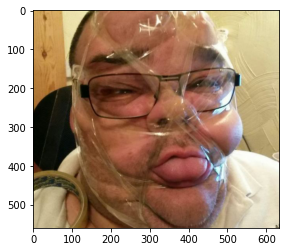

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

img_path = 'pic1.png'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

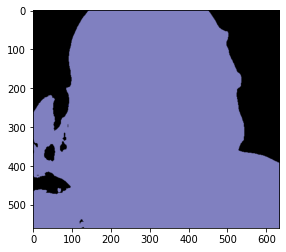

background
chair
person


In [2]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

plt.imshow(output)
plt.show()

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    

(560, 634)


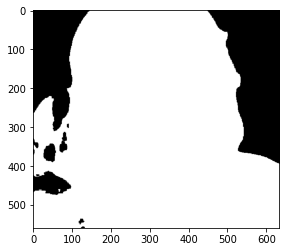

In [3]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[15]

seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

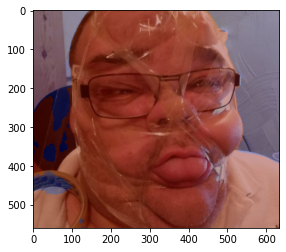

In [4]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

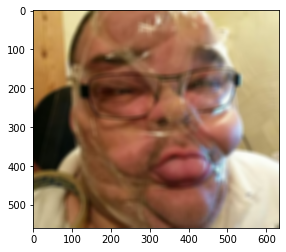

In [5]:
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

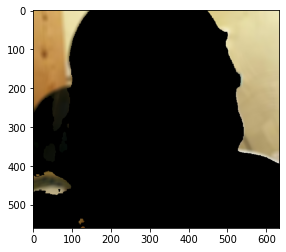

In [6]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

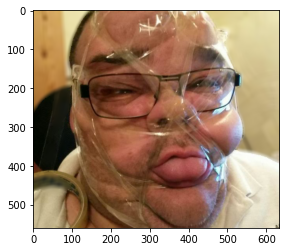

In [7]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점
먼저 opencv가 분리한 segmentation에는 의자, 사람, background 이 세 가지를 인식했습니다.

여기서 사람만 추출했는데, 사람 영역에 의자가 있더군요

사람을 정확하게 캐치하지 못 했습니다

## 어떻게 이 문제를 해결할 수 있을까?
저는 사람을 세세하게 인식하는 다른 모델을 써야만 해당 문제를 해결할 수 있을 거라 생각했습니다

그럼 배경과 사람을 분리해주는 작업이 있지 않을까? 싶어서 생각해보니
일명 누끼 따기라는 작업이 있더군요

그럼 누끼 따기 작업을 코딩으로 구현한게 있지 않을까? 싶어서 영어로 번역해서 알아봤습니다

그 결과

인터넷을 돌아다니다가 opencv 기능을 이용해서
비디오에서 사용자가 지정한 색상 범위 이외에는 삭제하는 기능이 있어, 이를 이용해서 살색 부분만 추출해보고자 했습니다

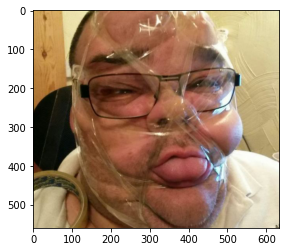

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


output_path = 'pic1.png'
img = cv2.imread(output_path)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(rgb)

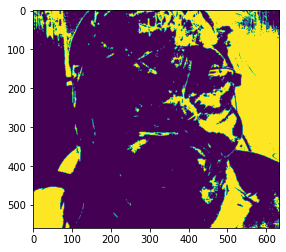

In [9]:
# rgb 피부색은 그림판으로 추출해서 범위를 지정했습니다

lower_blue = np.array([100,100,120])
upper_blue = np.array([150,255,255])

lower_green = np.array([50, 150, 50])
upper_green = np.array([80, 255, 255])

lower_red = np.array([150, 50, 50])
upper_red = np.array([180, 255, 255])

lower_skin = np.array([150, 110, 90])
upper_skin = np.array([245, 220, 190])

mask = cv2.inRange(rgb, lower_blue, upper_blue)
mask1 = cv2.inRange(rgb, lower_green, upper_green)
mask2 = cv2.inRange(rgb, lower_red, upper_red)
mask3 = cv2.inRange(rgb, lower_skin, upper_skin)

plt.imshow(mask3)

예상보다 결과가 참혹합니다

배경이 크로마키거나, 배경과 인물 색의 대비가 강하면 꽤 가능성이 있는 기능이겠지만,
현 이미지는 배경이 복잡하고, 인물과의 대비가 강하지 않아 참혹한 결과가 나온 거 같습니다

ㅁ

## 그래서 깃허브에서 찾아봤는데, 정말 깔끔하게 background를 없애주는 모듈을 발견했습니다
해당 모듈은 아래 코드를 실행하면 이루어집니다

**아래 코드를 실행하면, 셀이 비약적으로 길어지기 때문에 마크다운으로만 표기했습니다**

출처
:
https://github.com/danielgatis/rembg


! pip install rembg

In [10]:
from rembg.bg import remove
import numpy as np
import io
from PIL import Image


# input_path에 background를 지우고 싶은 이미지의 경로를 넣어줍니다
# 그리고 out_path에는 background를 지운 이미지를 저장할 경로와 이름을 넣어줍니다

input_path = 'pic1.png'
output_path = 'done/out.png'

f = np.fromfile(input_path)
result = remove(f)
img = Image.open(io.BytesIO(result)).convert("RGBA")
img.save(output_path)


(560, 634, 3)
634


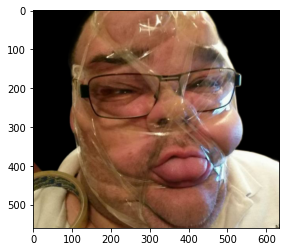

In [11]:
import matplotlib.image as img

im = cv2.imread(output_path)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

print(im.shape)
print(len(im[0]))

plt.imshow(im)


# 거의 완벽하게
background를 삭제한 이미지를 얻을 수 있습니다

opencv로 추출한 이미지보다 얼마나 더 좋은지 비교해보겠습니다

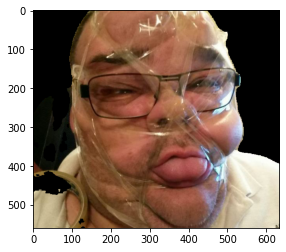

In [12]:
face_mask = 255-img_mask
face_mask_color = cv2.cvtColor(face_mask, cv2.COLOR_GRAY2BGR)
face_bg_mask = cv2.bitwise_not(face_mask_color)
face_bg_blur = cv2.bitwise_and(img_orig, face_bg_mask)

plt.imshow(cv2.cvtColor(face_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

opencv 기능만을 이용해서 background를 삭제했을 때 noise hole이 생기거나,
얼굴이 아닌 부분도 추출하게 됩니다

(마스크 영역을 따로 보면, 의자까지 추출된 것을 확인할 수 있습니다)

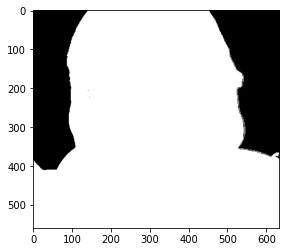

In [13]:
lower_mask = np.array([0, 1, 0])
upper_mask = np.array([255, 255, 255])


im_mask = cv2.inRange(im, lower_mask, upper_mask)


plt.imshow(im_mask, cmap='gray')

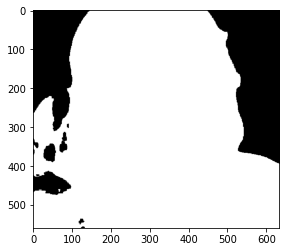

In [14]:
plt.imshow(seg_map, cmap='gray')
plt.show()

알파 채널로 확인해봐도 더 깨끗하다는 것을 알 수 있습니다


segmentation model 중 사람을 단순 클래스로 인식하는 모델이 있고,

사람을 여러 클래스로 분리해서 인식하는 모델이 있습니다

얼굴 세부 클래스 인식 모델:
https://github.com/zllrunning/face-parsing.PyTorch

해당 익스 노드에서는 사람을 단순 클래스로 인식하는 모델로 사람을 인식해서 background를 삭제했습니다
즉 모델 선정이 알맞지 않았다고 생각합니다

그럼 rembg를 이용해서 아웃포커싱 이미지를 만들어보겠습니다

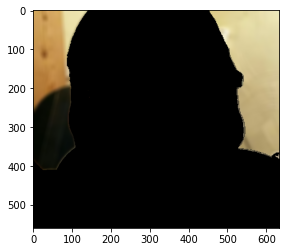

In [15]:
im_mask_color = cv2.cvtColor(im_mask, cv2.COLOR_GRAY2BGR)
im_bg_mask = cv2.bitwise_not(im_mask_color)
im_bg_blur = cv2.bitwise_and(img_orig_blur, im_bg_mask)
plt.imshow(cv2.cvtColor(im_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

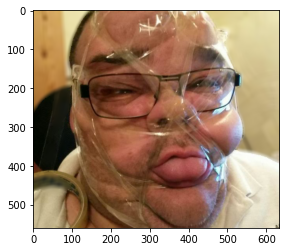

In [16]:
im_concat = np.where(im_mask_color==255, img_orig, im_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

큰 차이가 나지 않아 배경을 다른 이미지로 바꿔보겠습니다

(560, 634, 3)


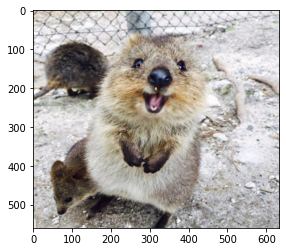

In [17]:
env_path = 'quokka.png'
env_orig = cv2.imread(env_path) 
env_cro = cv2.resize(env_orig, dsize=(634, 560))

print(env_cro.shape)
plt.imshow(cv2.cvtColor(env_cro, cv2.COLOR_BGR2RGB))
plt.show()

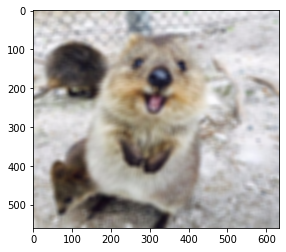

In [18]:
env_cro_blur = cv2.blur(env_cro, (13,13))  
plt.imshow(cv2.cvtColor(env_cro_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
print(im_mask_color.shape)
print(env_cro.shape)
print(im_bg_blur.shape)

(560, 634, 3)
(560, 634, 3)
(560, 634, 3)


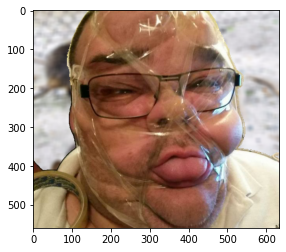

In [25]:
im_concat = np.where(im_mask_color==255, img_orig, env_cro_blur)
plt.imshow(cv2.cvtColor(im_concat, cv2.COLOR_BGR2RGB))
plt.show()

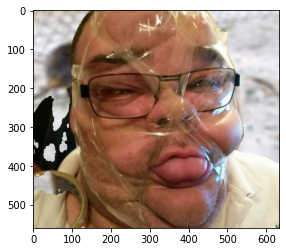

In [27]:
im_concat = np.where(img_mask_color==255, img_orig, env_cro_blur)
plt.imshow(cv2.cvtColor(im_concat, cv2.COLOR_BGR2RGB))
plt.show()

배경을 바꾸니 segmentation의 성능을 직관적으로 볼 수 있습니다

# 회고

개인적으로 이번 프로젝트는 치트키를 썼다고 생각합니다

코드상으로 데이터를 전처리를 해서 프로젝트를 마무리한 게 아니라,
그냥 좋은 모델을 찾아서 적용하는 걸로 프로젝트를 마무리했기 때문입니다.


## 어려웠던 점

모델을 그대로 쓰기 때문에 어려웠던 점은 없었습니다


## 새로 배운 내용

opencv의 segmentation의 성능이 사물 근접샷에는 적절하지 않다는 사실과,
opencv말고도 segmentation을 해주는 모델이 있다는 사실을 알게 되었습니다

제가 쓴 rembg 이외에도
https://github.com/zllrunning/face-parsing.PyTorch
face_parsing이라는 모델도 있더군요

근데 이 모델은 제가 쓰는 방법을 몰라 rembg를 선택했습니다
